In [77]:
import torch
from torch import nn
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"{torch.__version__} running on {device}")

2.4.0+cu121 running on cuda


In [78]:
# import my helper files
import individuals as inds
import fashion_mnist_to_dl as fmnist

# GP Run for Image Classification
Your problem needs to fulfill the following criteria.
1. It is an image classification problem.
2. You supply marked training images and marked validation images.

Within those, the run is flexible and adapts itself to your problem.
Now, please describe your images and problem by setting those global variables:

In [79]:
IMAGE_WIDTH = fmnist.IMAGE_WIDTH # <-- number of width-pixels
IMAGE_HEIGHT = fmnist.IMAGE_HEIGHT # <-- number of height-pixels
COLOUR_CHANNEL_COUNT = fmnist.COLOUR_CHANNEL_COUNT # <-- RGB images would have 3
CLASSIFICATION_CATEGORIES_COUNT = fmnist.CLASSIFICATION_CATEGORIES_COUNT # <-- the amount of possible categories of which each image shall be marked with one

MINI_BATCH_SIZE = fmnist.CLASSIFICATION_CATEGORIES_COUNT # was chosen in the dataloaders
fmnist.train_dl, fmnist.test_dl

(<torch.utils.data.dataloader.DataLoader at 0x7f3871487020>,
 <torch.utils.data.dataloader.DataLoader at 0x7f3870f77a10>)

In [80]:
testX = torch.randn(COLOUR_CHANNEL_COUNT,IMAGE_WIDTH,IMAGE_HEIGHT).to(device)

## GP Code
Now we need to decide the genetic stuff.
1. Initial Population
2. Fitness Measure
3. Selection
4. Genetic Operators
    - Cloning or Crossover
    - Mutation
    
### Hyperparameter-landscape is vast. Here's a list:
- Net architecture
    - kind of layers, number of layers
        - for convolution/pooling: kernel size, stride, padding, (dilation) **[implemented]**
    - number of neurons per layer
    - activation function for each layer
- cost function
    - base term (e.g. square cost, log-likelihood, cross-entropy, ect.)
    - toppings 
        - regularization of weights (L2, L1, dropout, etc.)
- weights and biases optimization technique (= optimizer)
    - SGD (= stochastic gradient descent)
    - Hessian technique, i.e. momentum-based descent
    - PyTorch's various other (e.g. *Adam* optimizer)
- learning parameters
    - η ... learning rate
        - constant, or epoch-dependent, or accuracy-dependent, or a mix
    - \# of epochs
        - constant, or early stopping
    - (`mini_batch_size` - this one might be canonical)

## The Individuals' Class
- I think I want to define a class for one `nn.Sequential` 2d-block
    - All possible instances should be concatenable with all possible instances
    - The first gene is not allowed to choose `~.in_channels`, it must match `COLOUR_CHANNEL_COUNT`
    - Every gene but the first is not allowed to choose `~.in_channels`, it must match `~.out_channels` of the prior gene
- We construct an `NN_individual` from an `NN_dna` class that contains all the genetic information necessary
- We add `device` and fitness dictionaries as member variables

In [81]:
print(inds.Gene_2d_block(IMAGE_WIDTH, 3).toString())

out_channels = 3 <-- (28 x 28)
conv_2d (kernel, stride, padding) =	(3, 1, 1) --> (28 x 28)
max_pool_2d (kernel, stride, padding) =	(2, 2, 0) --> (14 x 14)


In [82]:
testIndividual = inds.NN_individual(COLOUR_CHANNEL_COUNT, CLASSIFICATION_CATEGORIES_COUNT, device=device)#genes_2d_block=[Gene_2d_block(out_channels=4), Gene_2d_block(out_channels=7)])
testIndividual, testIndividual(testX)

(NN_individual(
   (blocks_2d): Sequential()
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (lazyLin): Linear(in_features=784, out_features=10, bias=True)
   (loss_fn): CrossEntropyLoss()
 ),
 tensor([[-0.7405, -0.9395, -0.2154,  0.0306, -0.1191, -0.0335, -0.1752, -0.1824,
           0.3180,  0.2290]], device='cuda:0', grad_fn=<AddmmBackward0>))

### Bundling Multiple `NN_individual`s Into a Population
Create a class called population of which an instance acts as an array of `NN_individual`s with extra functionality that regards the whole population.

In [83]:
# created by Chat
class NN_population:
    ### Magic Methods ###
    def __init__(self, individuals: list[inds.NN_individual]): self.individuals = individuals
    def __getitem__(self, index): return self.individuals[index]  # magic pop[i] access
    def __len__(self): return len(self.individuals)  # magic len(pop)
    def __setitem__(self, index, value): self.individuals[index] = value  # magic pop[i] = value
    def __iter__(self): return iter(self.individuals)  # magic for-iterations
    
    def plot_accs(self, elapsed_time = 0):
        plt.figure(figsize=(15, 6))  # Set the figure size
        for ind in sorted(self.individuals, key=lambda ind: ind.running_acc, reverse=True):
            x = list(ind.accs.keys())  # Extract the epoch/batch labels (x-axis)
            y = [float(val.cpu().item()*100) for val in ind.accs.values()]  # Convert tensors to floats
            # Plot each individual's accuracies
            plt.plot(x, y, marker='o', linestyle='-', label=f"{ind.name} [{ind.dna.toString()}] ({ind.running_acc:.2f} within {ind.elapsed_training_time:.1f}s)")
        plt.xlabel('Epoch@Batch')  # Label for the x-axis
        plt.ylabel('Accuracy [%]')     # Label for the y-axis
        extra_title = "" if elapsed_time == 0 else f" (took {elapsed_time:.2f}s)"
        plt.title('Accuracy per Epoch and Batch' + extra_title)  # Title of the plot
        plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
        plt.grid(True)  # Show grid
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1)) # legend on the right
        plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust plot area size to leave space for the legend
        plt.show()

### Create Random Population

In [84]:
import random

In [85]:
def create_random_2d_block(input_image_size, max_kernel_size: int) -> inds.Gene_2d_block:
    conv_kernel_size=min(random.randint(1,min(input_image_size, max_kernel_size)), random.randint(1,min(input_image_size, max_kernel_size))) # kernel must be smaller than image size!
    conv_stride=random.randint(1,conv_kernel_size)
    conv_padding=random.randint(0,conv_kernel_size//2) # PyTorch: "pad should be at most half of effective kernel size"
    after_conv_i_s = inds.output_size(input_image_size, conv_kernel_size, conv_stride, conv_padding)
    pool_kernel_size=min(random.randint(1,min(after_conv_i_s, max_kernel_size)), random.randint(1,min(after_conv_i_s, max_kernel_size)), random.randint(1,min(after_conv_i_s, max_kernel_size)))
    if conv_kernel_size == 0 or pool_kernel_size == 0:
        print("Exception! A kernel size is 0, which is not allowed.")
        print(f"input_image_size {input_image_size}, max_kernel_size {max_kernel_size}, conv_kernel_size {conv_kernel_size}, conv_stride {conv_stride}, conv_padding {conv_padding}, after_conv_image_size {after_conv_i_s}, pool_kernel_size {pool_kernel_size}")
    pool_stride=max(random.randint(1,pool_kernel_size), random.randint(1,pool_kernel_size))
    pool_padding=random.randint(0,pool_kernel_size//2) # PyTorch: "pad should be at most half of effective kernel size"
    return inds.Gene_2d_block(
        input_image_size=input_image_size,
        out_channels=random.randint(3,15), # not fine-tuned
        conv_kernel_size=conv_kernel_size,
        conv_padding=conv_padding,
        conv_stride=conv_stride,
        pool_kernel_size=pool_kernel_size,
        pool_padding=pool_padding,
        pool_stride=pool_stride
    )

def update_and_check_2d_block_stack(gene_2d_blocks: list[inds.Gene_2d_block]):
    protocol = ""
    if len(gene_2d_blocks) == 0: return "no block in the stack"
    if gene_2d_blocks[0].input_image_size != IMAGE_HEIGHT:
        gene_2d_blocks[0].input_image_size != IMAGE_HEIGHT
        protocol += f"block[0]'s input_image_size was set to IMAGE_HEIGHT ({IMAGE_HEIGHT}), " 
    for i, block in enumerate(gene_2d_blocks):
        if i > 0 and block.input_image_size != gene_2d_blocks[i-1].output_image_size:
            block.input_image_size = gene_2d_blocks[i-1].output_image_size
            protocol += f"block[{i}]'s input_image_size was set to block[{i-1}]'s output_image_size ({block.input_image_size}), "
            block.after_conv_image_size = inds.output_size(block.input_image_size, block.conv_kernel_size, block.conv_stride, block.conv_padding) # update the effective image size after convolution
        if block.input_image_size < block.conv_kernel_size:
            block.conv_kernel_size = block.input_image_size
            protocol += f"block[{i}]'s conv_kernel_size was decreased to input_image_size ({block.conv_kernel_size}), "
        if block.conv_padding > block.conv_kernel_size // 2:
            block.conv_padding = block.conv_kernel_size // 2
            protocol += f"block[{i}]'s conv_padding was decreased to conv_kernel_size//2 ({block.conv_kernel_size // 2}), "
        if block.after_conv_image_size < block.pool_kernel_size:
            block.pool_kernel_size = block.after_conv_image_size
            protocol += f"block[{i}]'s pool_kernel_size was decreased to after_conv_size ({block.pool_kernel_size}), "
        if block.pool_padding > block.pool_kernel_size // 2:
            block.pool_padding = block.pool_kernel_size // 2
            protocol += f"block[{i}]'s pool_padding was decreased to pool_kernel_size//2 ({block.pool_kernel_size // 2}), "
    return protocol
    
def create_random_population(pop_size: int, 
                             max_2d_block_count: int = 3, 
                             max_kernel_size: int = 11,
                             name_prefix="nn",
                             device=device,
                             print_summary: bool = True) -> NN_population:
    population = []
    for i in range(pop_size):
        genes_2d_block = []
        input_image_size = IMAGE_HEIGHT # = IMAGE_WIDTH (assumed)
        name=name_prefix+str(i)
        if print_summary: print(f"Individual '{name}' <-- ({input_image_size} x {input_image_size})")
        for j in range(random.randint(1, max_2d_block_count)):
            if print_summary: print(f"\tBlock {j}")
            # create a random conv-pool block and store the corresponding new input_image_size for the block thereafter
            block = create_random_2d_block(input_image_size, max_kernel_size)
            input_image_size = block.output_image_size
            genes_2d_block.append(block)
            if print_summary: print(f"{block.toString(tab_count=2)} --> ({input_image_size} x {input_image_size})")
        dna = inds.NN_dna(blocks_2d=genes_2d_block,
                     loss_fn=random.randrange(len(inds.NN_dna.loss_fn_dict)),
                     optimizer=random.randrange(len(inds.NN_dna.optimizer_dict)),
                    # here you can change the remaining hyperparameters
                    )
        population.append(inds.NN_individual(COLOUR_CHANNEL_COUNT, CLASSIFICATION_CATEGORIES_COUNT, dna=dna, name=name, device=device))
    return NN_population(population)
testPop = create_random_population(pop_size=7, max_2d_block_count=3, print_summary=False)
try:
    for ind in testPop:
        ind.eval()
        with torch.inference_mode():
            ind(testX)
except:
    print("oh, oh! exception")

### Fitness Evaluation
We want a population that:
- achieves high (validation/test data) accuracy after training
    - the final accuracy `acc(NN1(t_final))` of an individual `NN1` is used
- trains fast, i.e. takes little CPU time to achieve high accuracy called **Running Accuracy**
    - the individual's accuracy `acc(NN1(t))` is summed over given timestamps `t`, like `Σ_t{acc(NN1(t))}`
    - possibly we want to value early accuracy more, summing `Σ_t{acc(NN1(t))/t}` instead

In [86]:
import torchmetrics
from torchmetrics import functional
import time
import torch.nn.functional as F

In [87]:
def train_model_one_batch(ind: inds.NN_individual,       # <- model to be trained in-place
                          X, y,                     # <- train batch, e.g. X.shape = [32, 1, 28, 28]
                          ) -> tuple[float, float]: # -> return (train_loss, time that training took)
  train_loss = 0
  start_time = time.perf_counter() # Start timing
  ind.train()
  X, y = X.to(ind.device), y.to(ind.device)
  y_pred = ind(X)
  if inds.NN_dna.loss_fn_dict[ind.dna.loss_fn_gene]['1hot']: # <- does the loss_fn need one-hot encoding?
    loss = ind.loss_fn(y_pred, F.one_hot(y, num_classes=CLASSIFICATION_CATEGORIES_COUNT).float())
  else:
    loss = ind.loss_fn(y_pred, y)
  train_loss += loss
  ind.optimizer.zero_grad()
  loss.backward()
  ind.optimizer.step()
  end_time = time.perf_counter() # Stop timing
  return (train_loss, end_time-start_time)

def test_model(ind: inds.NN_individual,            # <- model to be tested
               test_dl,                       # <- test dataloader (= multiple batches)
               ) -> tuple[float, float]:      # -> return (loss_total, acc_total)
  loss_total, acc_total = 0, 0
  ind.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dl):
      X, y = X.to(ind.device), y.to(ind.device)
      preds = ind(X)
      if inds.NN_dna.loss_fn_dict[ind.dna.loss_fn_gene]['1hot']: # <- does the loss_fn need one-hot encoding?
        loss_batch = ind.loss_fn(preds, F.one_hot(y, num_classes=CLASSIFICATION_CATEGORIES_COUNT).float())
      else:
        loss_batch = ind.loss_fn(preds, y)
      loss_total += loss_batch
      acc_batch = functional.accuracy(preds, y, task="multiclass", num_classes=CLASSIFICATION_CATEGORIES_COUNT)
      acc_total += acc_batch

    loss_total /= len(test_dl)
    acc_total /= len(test_dl)
  return (loss_total, acc_total)

We now train the whole population simultaneously, populating the individuals' fitness value parameters:
- `train_losses` ... a dictionary filled with the train loss function results for each batch (independent of how often we test, because it comes for free)
- `test_losses` ... same as above but evaluating on test data instead, and only whenever we choose to test (obviously; this is not free)
- `accs` ... a dictionary with same keys as `test_losses`, filled with the fraction of correct model predictions by total number of predictions
- `acc` ... a single number - the most recent accuracy (defined similarly as `accs`)
- `running_acc` ... a single number - the sum of all known accuracies (i.e. at all times where we tested), divided by the time
    - here, we exclude the first accuracy because the division is very big in that case, and accuracy only depends mainly on weight initialization

In [88]:
from tqdm import tqdm
from torch.utils.data import Subset
from IPython.display import clear_output
from torch.utils.data import DataLoader

In [89]:
def train_and_evaluate_gen(pop: NN_population,
                           train_dl,  # <- train dataloader
                           test_dl,   # <- test dataloader
                           testing_interval = 300,      # <- after how many batches should we test an individual
                           testing_data_fraction = 1.0, # <- amount of test_dl to be used (1=100% takes a lot of time)
                           training_data_fraction = 1.0,# <- amount of train_dl to be used (1=100% takes a lot of time)
                           epochs = 5,
                           live_plot = True,
                           only_last_plot = False,
                           no_plot = False):
  start_time = time.perf_counter() # Start timing

  # prepare the reduced testing data loader
  random_batch_indices = random.sample(range(len(test_dl)), int(len(test_dl) * testing_data_fraction)) # random indices (without replacement)
  test_subset = Subset(test_dl.dataset, random_batch_indices)
  test_subset_dl = DataLoader(test_subset, batch_size=test_dl.batch_size, shuffle=False, num_workers=test_dl.num_workers)

  # prepare the reduced training data loader ()
  first_indices = list(range(int(len(train_dl)*train_dl.batch_size * training_data_fraction)))
  train_subset = Subset(train_dl.dataset, first_indices)
  train_subset_dl = DataLoader(train_subset, batch_size=train_dl.batch_size, shuffle=False, num_workers=train_dl.num_workers)

  # re-initialize pop's fitness values:
  for ind in pop:
    ind.acc, ind.running_acc = 0, 0
    ind.train_losses, ind.test_losses, ind.accs = {}, {}, {}
  
  # train each individual "simultaneously" by making the epoch-loop the outer one
  for epoch in range(epochs):
    print(f"*** Commencing epoch {epoch+1} / {epochs} for {len(pop)} individuals, one line each. ***")
    for i in range(len(pop)):
      p_bar = tqdm(enumerate(train_subset_dl))
      for batch, (X, y) in p_bar:
        # train the model (update the weights and biases of the NN pop[i])
        pop[i].train_losses[f"e_{epoch}@b_{batch}"], elapsed_batch_training_time = train_model_one_batch(pop[i], X=X, y=y)
        pop[i].elapsed_training_time += elapsed_batch_training_time
        if batch % testing_interval == 0: 
          # test the model and store the results
          pop[i].test_losses[f"e_{epoch}@b_{batch}"], pop[i].accs[f"e_{epoch}@b_{batch}"] = test_model(pop[i], test_dl=test_subset_dl)
          p_bar.set_description(f"{i+1}. {pop[i].name} [{pop[i].dna.toString()}] {pop[i].accs[f"e_{epoch}@b_{batch}"]*100:.1f}%") # update the progress bar to display the current accuracy
          if batch != 0: # don't use the start/benchmark test as this depends mostly on luck of weight initialization
            pop[i].running_acc += pop[i].accs[f"e_{epoch}@b_{batch}"] / pop[i].elapsed_training_time
          if live_plot and not only_last_plot and not no_plot:
            clear_output(wait=True)
            pop.plot_accs(time.perf_counter() - start_time)
      pop[i].test_losses[f"e_{epoch}@end"], pop[i].accs[f"e_{epoch}@end"] = test_model(pop[i], test_dl=test_dl) # latest precise values
      pop[i].acc = pop[i].accs[f"e_{epoch}@end"] # store the very last known accuracy
      if not live_plot and not only_last_plot and not no_plot:
        clear_output(wait=True)
        pop.plot_accs(time.perf_counter() - start_time)
    # here we could select directly, i.e. before the whole train_dl over max_epochs no. of iterations has been trained

  if not no_plot and not only_last_plot:
    clear_output(wait=True)
    pop.plot_accs(time.perf_counter() - start_time)
  elif not no_plot and only_last_plot:
    pop.plot_accs(time.perf_counter() - start_time)
  else:  
    print(f"This took {time.perf_counter() - start_time:.2f}s.")
      

### Mutate
Should be guided by randomness, and not too radical.
1. Fix a bound of *radicalities* fixed at 1.
2. Each possible operation of mutation needs to come with a *factor of impact* **λ**
    - e.g. delete/add 2d block: **λ = 5**
    - e.g. learning rate times 1.1: **λ = 0.5**
3. Now we spin the wheels for each call of `mutate_individual`:
    - random radicality **0 < R < 1**
    - random raw likelihood **0 < p < 1** for each possible operation
    - execute an operation iff **λ•p < R** where **λ** and **p** correspond to the operation in question

In [90]:
import copy

In [91]:
MAX_KERNEL_SIZE = 11
class Mutation():
    def __init__(self):
        self.R = random.random() # <- radicality of this mutation instance

    ### factors of impact ###
    impact_lr_factor_1_1=.3
    impact_lr_factor_10=3
    impact_add_neuron_to_2d_block=1
    impact_delete_neuron_from_2d_block=1
    impact_add_2d_block=5
    impact_delete_2d_block=5
    impact_increase_kernel=.8
    impact_decrease_kernel=.8
    impact_change_optimizer=5
    impact_change_loss_fn=5

    ### possible operations (p_raw = 0 will happen most likely, p_raw = 1 least likely, p_raw = -1 definitely) ###
    def lr_factor_1_1(self, dna: inds.NN_dna, p_raw: float = -1):
        if p_raw * self.impact_lr_factor_1_1 < self.R:
            if random.random() > .5:
                dna.lr *= 1.1
                return "multiplied lr by 1.1"
            else:
                dna.lr /= 1.1
                return "divided lr by 1.1"
    def lr_factor_10(self, dna: inds.NN_dna, p_raw: float = -1):
        if p_raw * self.impact_lr_factor_10 < self.R:
            if random.random() > .5:
                dna.lr *= 10
                return "multiplied lr by 10"
            else:
                dna.lr /= 10
                return "divided lr by 10"
    def add_neuron_to_2d_block(self, dna: inds.NN_dna, p_raw: float = -1):
        if p_raw * self.impact_add_neuron_to_2d_block < self.R:
            if len(dna.blocks_2d_gene) == 0: return None
            layer_nr = random.randrange(0, len(dna.blocks_2d_gene))
            dna.blocks_2d_gene[layer_nr].out_channels += 1
            return f"added neuron to 2d block no. {layer_nr}"
    def delete_neuron_from_2d_block(self, dna: inds.NN_dna, p_raw: float = -1):
        if p_raw * self.impact_delete_neuron_from_2d_block < self.R:
            if len(dna.blocks_2d_gene) == 0: return None
            layer_nr = random.randrange(0, len(dna.blocks_2d_gene))
            if dna.blocks_2d_gene[layer_nr].out_channels > 1: dna.blocks_2d_gene[layer_nr].out_channels -= 1
            return f"deleted neuron from 2d block no. {layer_nr}"
    def add_2d_block(self, dna: inds.NN_dna, p_raw: float = -1):
        if p_raw * self.impact_add_2d_block < self.R:
            layer_nr = random.randrange(0, len(dna.blocks_2d_gene) + 1)
            input_image_size = IMAGE_WIDTH if layer_nr == 0 else dna.blocks_2d_gene[layer_nr-1].output_image_size
            dna.blocks_2d_gene.insert(layer_nr, create_random_2d_block(input_image_size, MAX_KERNEL_SIZE))
            protocol = update_and_check_2d_block_stack(dna.blocks_2d_gene) # check whether this insertion "killed" the entity (and if yes: repair it)
            return f"added block @ {layer_nr} ({protocol})"
    def delete_2d_block(self, dna: inds.NN_dna, p_raw: float = -1):
        if p_raw * self.impact_delete_2d_block < self.R:
            if len(dna.blocks_2d_gene) == 0: return None
            layer_nr = random.randrange(0, len(dna.blocks_2d_gene))
            dna.blocks_2d_gene.pop(layer_nr)
            protocol = update_and_check_2d_block_stack(dna.blocks_2d_gene) # check whether this deletion "killed" the entity (and if yes: repair it)
            return f"deleted 2d block at {layer_nr} ({protocol})"
    def increase_kernel(self, dna: inds.NN_dna, p_raw: float = -1):
        if p_raw * self.impact_increase_kernel < self.R:
            if len(dna.blocks_2d_gene) == 0: return None
            layer_nr = random.randrange(0, len(dna.blocks_2d_gene))
            if random.random() > .5:
                if dna.blocks_2d_gene[layer_nr].conv_kernel_size < dna.blocks_2d_gene[layer_nr].input_image_size: # check whether the kernel may be increased
                    dna.blocks_2d_gene[layer_nr].conv_kernel_size += 1
                    return f"conv kernel += 1 of 2d block no. {layer_nr}"
            else:
                if dna.blocks_2d_gene[layer_nr].pool_kernel_size < dna.blocks_2d_gene[layer_nr].after_conv_image_size:
                    dna.blocks_2d_gene[layer_nr].pool_kernel_size += 1
                    return f"pool kernel +=1 of 2d block no. {layer_nr}"
    def decrease_kernel(self, dna: inds.NN_dna, p_raw: float = -1):
        if p_raw * self.impact_decrease_kernel < self.R:
            if len(dna.blocks_2d_gene) == 0: return None
            layer_nr = random.randrange(0, len(dna.blocks_2d_gene))
            if random.random() > .5:
                if dna.blocks_2d_gene[layer_nr].conv_kernel_size > 1 and dna.blocks_2d_gene[layer_nr].conv_padding*2 < dna.blocks_2d_gene[layer_nr].conv_kernel_size:
                    dna.blocks_2d_gene[layer_nr].conv_kernel_size -= 1
                    return f"conv kernel -= 1 of 2d block no. {layer_nr}"
            else:
                if dna.blocks_2d_gene[layer_nr].pool_kernel_size > 1 and dna.blocks_2d_gene[layer_nr].pool_padding*2 < dna.blocks_2d_gene[layer_nr].pool_kernel_size:
                    dna.blocks_2d_gene[layer_nr].pool_kernel_size -= 1
                    return f"pool kernel -= 1 of 2d block no. {layer_nr}"
    def change_optimizer(self, dna: inds.NN_dna, p_raw: float = -1):
        if p_raw * self.impact_change_optimizer < self.R:
            optimizer_index = random.randrange(0, len(inds.NN_dna.optimizer_dict))
            if optimizer_index == dna.optimizer_gene: return None
            dna.optimizer_gene = optimizer_index
            return f"changed optimizer to {inds.NN_dna.optimizer_dict[optimizer_index]}"
    def change_loss_fn(self, dna: inds.NN_dna, p_raw: float = -1):
        if p_raw * self.impact_change_loss_fn < self.R:
            loss_fn_index = random.randrange(0, len(inds.NN_dna.loss_fn_dict))
            if loss_fn_index == dna.loss_fn_gene: return None
            dna.loss_fn_gene = loss_fn_index
            return f"changed loss function to {inds.NN_dna.loss_fn_dict[loss_fn_index]['name']}"

def mutant_from_dna(dna_parent: inds.NN_dna, print_actions: bool = True, mutant_name = "NN", device = device) -> inds.NN_individual:
    # clone the dna (to not change the parent's dna)
    dna_mutant = copy.deepcopy(dna_parent) 

    # create a test batch (to check wether the mutant is still "alive")
    test_batch = torch.rand(MINI_BATCH_SIZE, COLOUR_CHANNEL_COUNT, IMAGE_WIDTH, IMAGE_HEIGHT).to(device)

    # create a mutation instance (this produces a radicality R)
    m = Mutation()
    if print_actions: print(f"Radicality in creation of '{mutant_name}': {m.R:.2g}")

    # Dynamically loop over all functions of the Mutation class
    for method_name in dir(m): # Loop through all attributes of the class
        if callable(getattr(m, method_name)) and not method_name.startswith("__"): # Filter to only functions (ignoring private methods and attributes)
            p_raw = random.random() # raw likelihood
            operation = getattr(m, method_name)
            mutation_healthy, deaths = False, 0
            while not mutation_healthy:
                dna_before_mutation = copy.deepcopy(dna_mutant) # clone the dna (to not change the parent's dna)
                effect = operation(dna_mutant, p_raw) # execute the operation
                mutant = inds.NN_individual(COLOUR_CHANNEL_COUNT, CLASSIFICATION_CATEGORIES_COUNT, dna_mutant, mutant_name, device)
                try: 
                    mutant(test_batch)
                    mutation_healthy = True
                except Exception as e:
                    if print_actions: print(f"\tLETHAL MUTATION ({effect}) (e: '{e}')")
                    dna_mutant = dna_before_mutation # restore to the state before lethal operation
                    deaths += 1
                    if deaths > 10: raise Exception("Too many deaths.")
            if effect != None and print_actions: print(f"- {effect}")
    return mutant

### GP Run
1. Create a random population of given POP_SIZE
2. `train_and_evaluate_gen` for one epoch
3. choose the half of `NN_individual`s that has the best `running_acc`
4. mutate each chosen NN **twice**
5. continue at *2.* unless you are already at gen FINAL_GEN

In [92]:
import pandas as pd
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
pd.set_option('display.expand_frame_repr', False)

In [93]:
def return_evolution_df(gens: list[NN_population]):
    inds = sorted([gens[i][j] for i in range(len(gens)) for j in range(len(gens[i]))], key=lambda ind: ind.name) # all individuals of all generations, sorted by name
    rows = []
    for ind in inds:
        rows.append([ind.name, '['+ind.dna.toString()+']', ind.running_acc, ind.acc.item()*100, f"{ind.elapsed_training_time:.2f}s"])
    df = pd.DataFrame(rows, columns=['Name','DNA','running_acc','acc','training time'])#.sort_values(by='running_acc',ascending=False)
    cmap_bad_good = LinearSegmentedColormap.from_list("custom_map", ["darkred", "white", "green"])
    df_styled = df.style.background_gradient(cmap_bad_good).format({'running_acc':"{:.3g}",'acc':"{:.1f}"}).set_properties(**{'text-align': 'left'})

    return df_styled


In [94]:
def plot_generations(gens):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Store positions for each individual (to create branches)
    positions = {}  
    branch_lines = []
    colors = {}  # To assign a unique color for each initial individual
    initial_names = [ind.name for ind in gens[0]]  # Get the names of initial individuals

    # Generate a colormap with distinct colors for each initial individual
    color_map = plt.colormaps.get_cmap('tab10')  # Get a colormap with enough unique colors

    for i, name in enumerate(initial_names):
        colors[name] = color_map(i)

    # Plot each generation
    for i, gen in enumerate(gens):
        for ind in gen:
            name = ind.name
            # Find the root ancestor (initial individual) for this individual
            root_name = name.split('.')[0]

            # Determine parent (if exists)
            parent_name = name.rsplit('.', 1)[0] if '.' in name else None

            # Store the current generation and its value for the plot
            x = i  # Generation is the x-axis
            y = ind.acc.cpu()*100  # Value is the y-axis
            
            # Add the individual to the positions dict
            if name not in positions:
                positions[name] = (x, y)

            # If the individual has a parent, create a branch line
            if parent_name and parent_name in positions:
                parent_x, parent_y = positions[parent_name]
                branch_lines.append([(parent_x, parent_y), (x, y), root_name])

            # Plot the individual as a point (using root_name color)
            ax.scatter(x, y, color=colors[root_name])

    # Draw the branch lines
    for branch in branch_lines:
        (x0, y0), (x1, y1), root_name = branch
        ax.plot([x0, x1], [y0, y1], color=colors[root_name])

    # Create a legend for the initial individuals
    handles = [plt.Line2D([0], [0], color=colors[name], lw=2, label=name) for name in initial_names]
    ax.legend(handles=handles, title='Lineage', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Set labels
    ax.set_xlabel("Generations")
    ax.set_ylabel("Accuracy [%]")
    ax.set_title("NN Individual Evolution Across Generations")

    # Show the plot
    plt.show()


***** Gen. 1 / 2 *****
*** Commencing epoch 1 / 1 for 2 individuals, one line each. ***


1. NN0 [(14) adam L1 | 0.1] 7.0% : : 563it [00:04, 120.92it/s] 
2. NN1 [(4,12) SGD@λ0μ0 Hub@δ=10 | 0.1] 10.1% : : 563it [00:04, 127.06it/s]


This took 12.43s.
Radicality in creation of 'NN1.a': 0.24
- changed optimizer to SGD@λ1μ1
- multiplied lr by 1.1
Radicality in creation of 'NN1.b': 0.08
***** Gen. 2 / 2 *****
*** Commencing epoch 1 / 1 for 2 individuals, one line each. ***


1. NN1.a [(4,12) SGD@λ1μ1 Hub@δ=10 | 0.11] 8.3% : : 563it [00:04, 120.56it/s] 
2. NN1.b [(4,12) SGD@λ0μ0 Hub@δ=10 | 0.1] 15.4% : : 563it [00:05, 112.50it/s]


This took 13.64s.
******* SUMMARY *******


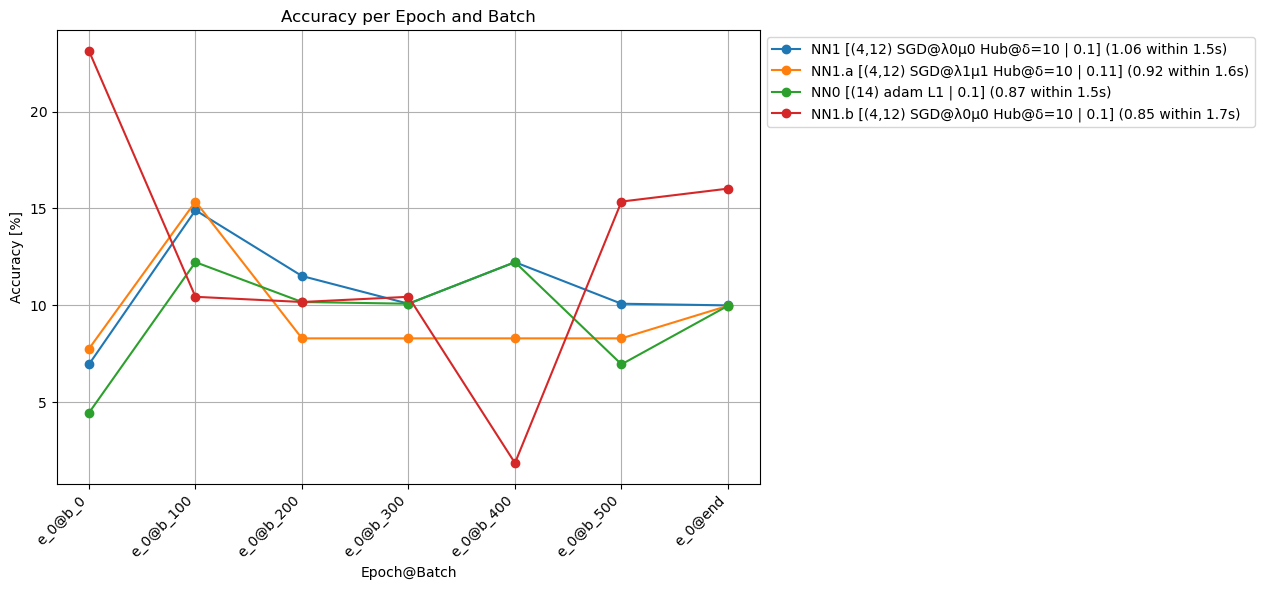

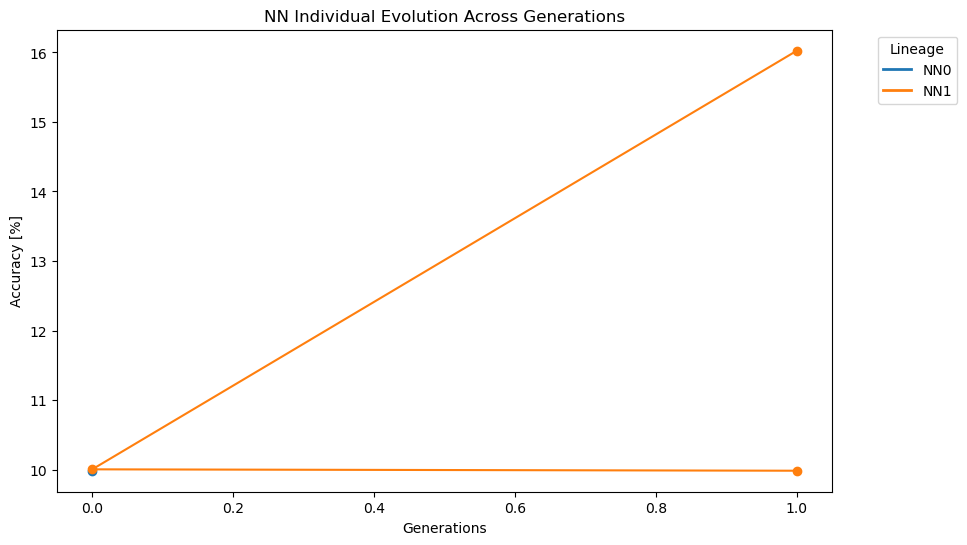

,Name,DNA,running_acc,acc,training time
0,NN0,[(14) adam L1 | 0.1],0.868,10.0,1.54s
1,NN1,"[(4,12) SGD@λ0μ0 Hub@δ=10 | 0.1]",1.06,10.0,1.51s
2,NN1.a,"[(4,12) SGD@λ1μ1 Hub@δ=10 | 0.11]",0.925,10.0,1.58s
3,NN1.b,"[(4,12) SGD@λ0μ0 Hub@δ=10 | 0.1]",0.85,16.0,1.68s


In [95]:
POP_SIZE = 2
FINAL_GEN = 2
MAX_2D_BLOCK_COUNT = 5
MAX_KERNEL_SIZE = 11

testing_interval = 100
epochs = 1
testing_data_fraction = .5
train_data_fraction = .3
derivatives = ['a','b']

gens = []

gens.append(create_random_population(POP_SIZE, max_2d_block_count=MAX_2D_BLOCK_COUNT, max_kernel_size=MAX_KERNEL_SIZE, name_prefix="NN", device=device, print_summary=False))
while(True):
    print(f"***** Gen. {len(gens)} / {FINAL_GEN} *****")
    train_and_evaluate_gen(gens[-1], fmnist.train_dl, fmnist.test_dl, testing_interval, testing_data_fraction, training_data_fraction=train_data_fraction, epochs=epochs, live_plot=False, only_last_plot=True, no_plot=True)
    if len(gens) == FINAL_GEN: break
    survivors = sorted(gens[-1], key=lambda ind: ind.running_acc, reverse=True)[:len(gens[-1]) // 2] # pick the top half (w.r.t. running_acc)
    gens.append(NN_population([mutant_from_dna(ind.dna, mutant_name=ind.name+"."+v, device=device) for ind in survivors for v in derivatives])) # mutate each survivor (as often as len(derivatives))

print(f"******* SUMMARY *******")
NN_population([gens[i][j] for i in range(len(gens)) for j in range(len(gens[i]))]).plot_accs()
plot_generations(gens)
return_evolution_df(gens)


TODO:
- change the mutation for the lr by using a Gauss distribution weighed by the p_raw and radicality
- increase the space of possible mutations / initializations